In [1]:
import os
from typing import Collection

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

from sample_and_train_utilities import (SiteDataSet,
                                        train_evaluate,
                                        analyse_runs)

This notebook follows the sample_and_train.ipynb notebook.

By now, the file structure should look like:

```text
./
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
|- original_split.txt
|
|- failed_downloads.csv
|- failed_web_pages.csv
|- failed_parsing.csv
|
|- Data
    |
    |- scPDB
        |- 1a2b_1
            |- protein.mol2
            |- site.mol2
            |- ...(other possible files from scPDB)
        |- ...(all scPDB entries)
    |
    |- SCOPe
        |- 2_08.csv
        |- ...(possibly other SCOPe versions)
    |
    |- Pages
        |- 1a2b_1.txt
        |- ...(all the source codes of scPDB web pages)
    |
    |- Folds
        |- 1.csv
        |- ...(other folds)
        |- test.csv
    |
    |- Atoms
        |- 1a2b_1.csv
        |- ...(csvs with atom coords and props)
    |
    |- Voxels
        |- 1
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 1)
        |
        |- 2
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 2)
    |
    |- CV
        |- pilot (folder for hyperparameter search)
            |- bs_128_do_0_cs_1
                |- train_loss.txt
                |- test_loss.txt
                |- true_labels.npy
                |- predictions.npy
            |- ... (other hyperparameter combinations)
```

By the end of this notebook, the file structure will look like:

```text
./
|- final_linear.pt (final linear model)
|- final_cnn.pt (final CNN model)
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
|- original_split.txt
|
|- failed_downloads.csv
|- failed_web_pages.csv
|- failed_parsing.csv
|
|- Data
    |
    |- scPDB
        |- 1a2b_1
            |- protein.mol2
            |- site.mol2
            |- ...(other possible files from scPDB)
        |- ...(all scPDB entries)
    |
    |- SCOPe
        |- 2_08.csv
        |- ...(possibly other SCOPe versions)
    |
    |- Pages
        |- 1a2b_1.txt
        |- ...(all the source codes of scPDB web pages)
    |
    |- Folds
        |- 1.csv
        |- ...(other folds)
        |- test.csv
    |
    |- Atoms
        |- 1a2b_1.csv
        |- ...(csvs with atom coords and props)
    |
    |- Voxels
        |- 1
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 1)
        |
        |- 2
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 2)
    |
    |- CV
        |- analysis (folder with aggregated CSVs)
        |- pilot (folder for hyperparameter search)
            |- bs_128_do_0_cs_1
                |- train_loss.txt
                |- test_loss.txt
                |- true_labels.npy
                |- predictions.npy
            |- ... (other hyperparameter combinations)
        |
        |- vs_1_cnn
            |- params.csv (parameters of the run)   
            |- 0
                |- train_loss.txt
                |- test_loss.txt
                |- true_labels.npy
                |- predictions.npy
            |- ... (other folds)
        |
        |- ... (other models)
```

In [2]:
# Default dirs and paths

FOLDS_DIR = 'Data/Folds'
VOXELS_DIR = 'Data/Voxels'
CV_LOGS = 'Data/CV'
CV_ANALYSIS = 'Data/CV/analysis' # dir to store aggregated CSVs
MODEL_DIR = '.' # dir to store models

# Models definitions

In [3]:
class LinearRegression(torch.nn.Module):

    """
    This model is basically a linear regression of a flattened sub-grid input
    """


    def __init__(self, voxel_size: int = 1):
        """
        Args:
            voxel_size (int, optional): voxel size to expect. Defaults to 1.
        """

        assert isinstance(voxel_size, int), f'voxel_size must be int, not {type(voxel_size)}'
        assert voxel_size in {1, 2}, f'currently only voxel_size 1 or 2 is supported'

        super().__init__()

        self.voxel_size = voxel_size

        self.model = self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear((16 // self.voxel_size) ** 3 * 8, 1),
        )

    def forward(self, x):
        return self.model(x)
    

class FlexibleCNN3D(torch.nn.Module):

    def __init__(self, dropout: float = 0.25,
                 channel_size: int | float = 2,
                 voxel_size: int = 1):
        """
        This Model will only be used for hyperparameter search during the pilot run

        Dropout will be used as it is after convolution layers and with a factor of 2 between dense layers.

        Channel size will be used with a factor of 16.

        Args:
            dropout (float, optional): dropout. Defaults to 0.25.
            channel_size (int | float, optional): relative channel size. Defaults to 2.
            voxel_size (int, optional): voxel size to expect. Defaults to 1.
        """

        # Check the input
        assert isinstance(dropout, float | int), f'dropout must be float or int, not {type(dropout)}'
        assert 0 <= dropout, f'dropout must be at least 0, not {dropout}'
        assert isinstance(channel_size, float | int), f'channel_size must be int or float, not {type(channel_size)}'
        assert 0 < channel_size, f'channel_size must be positive, not {channel_size}'
        assert isinstance(voxel_size, int), f'voxel_size must be int, not {type(voxel_size)}'
        assert voxel_size in {1, 2}, f'currently only voxel_size 1 or 2 is supported'
        
        super().__init__()

        # Store parameters
        self.dropout = dropout
        self.channel_size = channel_size
        self.voxel_size = voxel_size
        self.k = self.voxel_size ** 1.5

        # Model itself
        self.model = torch.nn.Sequential(
            torch.nn.Conv3d(8,
                            int(16 * self.channel_size * self.k),
                            kernel_size=8 // self.voxel_size,
                            padding='same'),
            torch.nn.ELU(),
            torch.nn.Conv3d(int(16 * self.channel_size * self.k),
                            int(16 * (self.channel_size + 1) * self.k),
                            kernel_size=4 // self.voxel_size,
                            padding='same'),
            torch.nn.ELU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(dropout),
            torch.nn.Conv3d(int(16 * (self.channel_size + 1) * self.k),
                            int(16 * (self.channel_size + 2) * self.k),
                            kernel_size=4 // self.voxel_size,
                            padding='same'),
            torch.nn.ELU(),
            torch.nn.Conv3d(int(16 * (self.channel_size + 2) * self.k),
                            int(16 * (self.channel_size + 3) * self.k),
                            kernel_size=4 // self.voxel_size,
                            padding='same'),
            torch.nn.ELU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(dropout),
            torch.nn.Flatten(),
            torch.nn.Linear((4 // self.voxel_size) ** 3 * int(16 * (self.channel_size + 3) * self.k),
                            int(128 * self.k)),
            torch.nn.ELU(),
            torch.nn.Dropout(dropout * 2),
            torch.nn.Linear(int(128 * self.k), 1)
        )

    def forward(self, x):
        return self.model(x)

# CV Loop

In [4]:
def cross_validation_loop(
                        cv_logs_dir: str = 'Data/CV',
                        folds_dir: str = 'Data/Folds',
                        reduction_factor: int = 2,
                        partially: float = 1,
                        augmented=False,
                        neg_to_pos_ratio=1,
                        voxel_size: int = 1,
                        distance_measure: str = 'euclidean',
                        distance_threshold: int = 4,
                        channels_to_use: Collection[str] = 'all',
                        voxels_dir: str = 'Data/Voxels',
                        batch_size: int = 128,
                        epochs: int = 12,
                        patience: int = 3,
                        shuffle_train: bool = True,
                        seed: int = 1234,
                        custom_run_name: str = None):
    """
    All-in-one function to perform cross_validation.

    IMPORTANT: if custom_run_name contains the word 'linear', a linear model will be initialized.

    Args:
        cv_logs_dir (str, optional): folder to store CV logs to. Defaults to 'Data/CV'.
        folds_dir (str, optional): folder to take folds information from. Defaults to 'Data/Folds'.
        reduction_factor (int, optional): how much the dataset will be reduced. Defaults to 2.
        partially (float, optional): . Defaults to 1.
        augmented (bool, optional): allows to use more PDB IDs for sampling. Defaults to False.
        neg_to_pos_ratio (int, optional): number of negative samples per positive sample. Defaults to 1 (balanced).
        voxel_size (int, optional): size of a voxel in Angström. Defaults to 1.
        distance_measure (str, optional): how to compute the distance to site centers. Defaults to 'euclidean'.
        distance_threshold (int, optional): at what distance from the true site center the sub-grids are considered positive. Defaults to 4.
        channels_to_use (Collection[str], optional): chemical channels to use. Defaults to 'all'.
        voxels_dir (str, optional): folder with precomputed voxelized proteins. Defaults to 'Data/Voxels'.
        batch_size (int, optional): batch size. Defaults to 128.
        epochs (int, optional): maximum number of epochs. Defaults to 12.
        patience (int, optional): criterion for early stopping. Defaults to 3.
        shuffle_train (bool, optional): shuffle the train DataLoader. Defaults to True.
        seed (int, optional): random seed for reproducibility. Defaults to 1234.
        custom_run_name (str, optional): name of the run / model. Defaults to None.
    """


    # Check the input (not all, the others will be checked anyway later)
    assert isinstance(cv_logs_dir, str), f'cv_logs_dir must be str, not {type(cv_logs_dir)}'
    assert isinstance(custom_run_name, str), f'custom_run_name must be str, not {type(custom_run_name)}'
    assert isinstance(seed, int), f'seed must be int, not {type(seed)}'
    assert 1 <= seed, f'seed be at least 1, not {seed}'
    assert isinstance(patience, int), f'patience must be int, not {type(patience)}'
    assert 1 <= patience, f'patience be at least 1, not {patience}'
    assert isinstance(batch_size, int), f'batch_size must be int, not {type(batch_size)}'
    assert 4 <= batch_size, f'batch_size must be at least 4, not {batch_size}'
    assert isinstance(epochs, int), f'epochs must be int, not {type(epochs)}'
    assert 1 <= epochs, f'epochs must be at least 1, not {epochs}'
    assert isinstance(shuffle_train, bool), f'shuffle_train must be bool, not {type(shuffle_train)}'

    # Set seed
    np.random.seed(seed)
    torch.random.manual_seed(seed)

    # Report
    print('Cross-Validation Loop')
    print(f'Reduction Factor: {reduction_factor}')
    print(f'Augmented: {augmented}')
    print(f'Partially: {partially}')
    print(f'N/P retio: {neg_to_pos_ratio}')
    print(f'Voxel Size: {voxel_size}')
    print(f'Distance Measure: {distance_measure}')
    print(f'Distance Threshold: {distance_threshold}')
    print(f'Channels Used: {channels_to_use}')
    print(f'Batch Size: {batch_size}')
    print(f'Epochs: {epochs}')
    print(f'Seed: {seed}')
    print(f'Name: {custom_run_name}')

    # Create a path
    path = os.path.join(cv_logs_dir, f'vs_{voxel_size}_{custom_run_name}')
    os.makedirs(path, exist_ok=True)
    
    # Save parameters to params.csv
    parameters = {'Reduction Factor': reduction_factor,
                  'Augmented': augmented,
                  'Partially': partially,
                  'N/P ratio': neg_to_pos_ratio,
                  'Voxel Size': voxel_size,
                  'Distance Measure': distance_measure,
                  'Distance Threshold': distance_threshold,
                  'Channels Used': channels_to_use,
                  'Batch Size': batch_size,
                  'Epochs': epochs,
                  'Patience': patience,
                  'Shuffle Train': shuffle_train,
                  'Seed': seed,
                  'Name': custom_run_name}
    
    parameters = pd.DataFrame(parameters.items(), columns=['Parameter', 'Value'])
    parameters.to_csv(os.path.join(path, 'params.csv'), sep='\t', index=False)

    # Extract all CV folds
    all_folds = [int(f.replace('.csv', '')) for f in os.listdir(folds_dir) if f.replace('.csv', '').isnumeric()]
    all_folds = sorted(all_folds)
    
    for i in range(len(all_folds) // 2):

        # Choose a pair of test folds
        test_folds = {all_folds[2*i], all_folds[2*i + 1]}
        print(f'\n{i+1}) Test Folds {test_folds}:\n')

        # Create a train set
        train_dataset = SiteDataSet(use_folds=set(all_folds) - test_folds,
                                        folds_dir=folds_dir,
                                        reduction_factor=reduction_factor,
                                        partially=partially,
                                        augmented=augmented,
                                        neg_to_pos_ratio=neg_to_pos_ratio,
                                        voxel_size=voxel_size,
                                        distance_measure=distance_measure,
                                        distance_threshold=distance_threshold,
                                        channels_to_use=channels_to_use,
                                        voxels_dir=voxels_dir,
                                        seed=seed)
        print(f'Train DataSet created: {len(train_dataset)}')

        # Create a test set
        test_dataset = SiteDataSet(use_folds=test_folds,
                                        folds_dir=folds_dir,
                                        reduction_factor=reduction_factor,
                                        partially=partially,
                                        augmented=augmented,
                                        neg_to_pos_ratio=neg_to_pos_ratio,
                                        voxel_size=voxel_size,
                                        distance_measure=distance_measure,
                                        distance_threshold=distance_threshold,
                                        channels_to_use=channels_to_use,
                                        voxels_dir=voxels_dir,
                                        seed=seed)
        print(f'Test DataSet created: {len(test_dataset)}')

        # Create Loaders
        train_loader = DataLoader(train_dataset, shuffle=shuffle_train, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
        print('DataLoaders Created')

        # Create a model according to the name
        if 'linear' in custom_run_name:
            model = LinearRegression(voxel_size=train_dataset.voxel_size)
        else:
            model = FlexibleCNN3D(dropout=0, channel_size=2, voxel_size=train_dataset.voxel_size)
        print(f'Model Created: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters')

        # Train and evaluate the model
        train_loss_per_epoch, test_loss_per_epoch, true_per_epoch, predictions_per_epoch = train_evaluate(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            patience=patience,
            pos_weight=neg_to_pos_ratio,
            device='cpu')

        # Save logs

        os.makedirs(os.path.join(path, str(i)), exist_ok=True)
        open(os.path.join(path, str(i), 'train_loss.txt'), 'w').write("\n".join(str(loss) for loss in train_loss_per_epoch))
        open(os.path.join(path, str(i), 'test_loss.txt'), 'w').write("\n".join(str(loss) for loss in test_loss_per_epoch))
        np.save(os.path.join(path, str(i), 'true_labels.npy'), np.array(true_per_epoch))
        np.save(os.path.join(path, str(i), 'predictions.npy'), np.array(predictions_per_epoch))

The cell below will run CV for the four models:

- Linear + voxel size 1
- CNN + voxel size 1
- Linear + voxel size 2
- CNN + voxel size 2

The logs will be stored in Data/CV by default.
Each model will create a folder like 'vs_1_linear'. Inside there will be distinct folder for each fold.

    IMPORTANT: it might take up to 30 hours and will generate about 10 Mb of files.

In [5]:
rerun = False
if rerun:
    cross_validation_loop(voxel_size=1, custom_run_name='linear', cv_logs_dir=CV_LOGS, folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)
    cross_validation_loop(voxel_size=1, custom_run_name='cnn', cv_logs_dir=CV_LOGS, folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)
    cross_validation_loop(voxel_size=2, custom_run_name='linear', cv_logs_dir=CV_LOGS, folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)
    cross_validation_loop(voxel_size=2, custom_run_name='cnn', cv_logs_dir=CV_LOGS, folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)

# CV Analysis

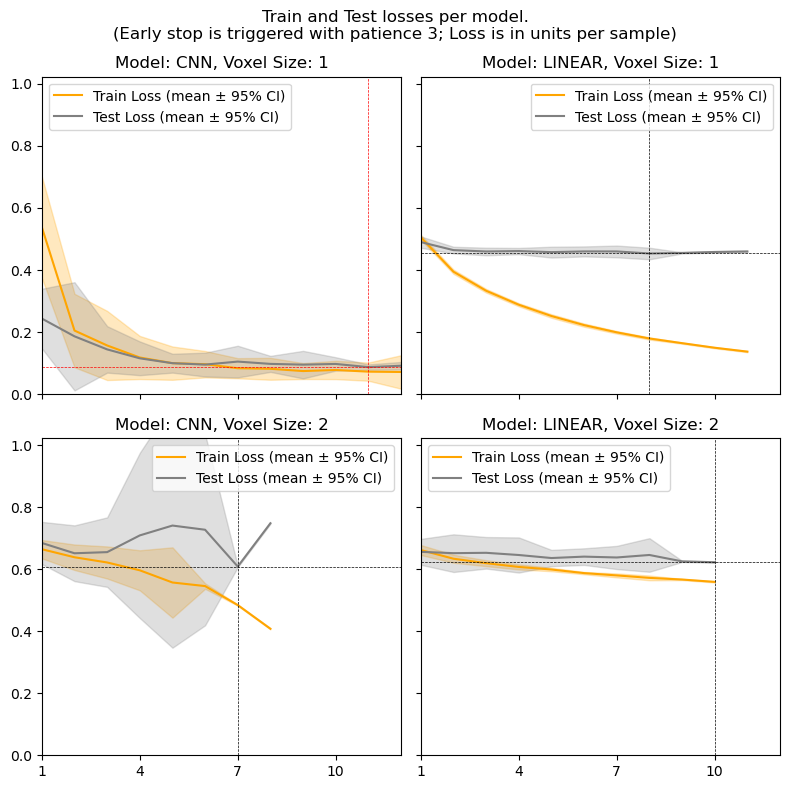

| model_name   |   voxel_size |   mean_best_epoch |   best_mean_loss | aps_print         | aucroc_print      |   mean_accuracy |   mean_f1 |
|:-------------|-------------:|------------------:|-----------------:|:------------------|:------------------|----------------:|----------:|
| cnn          |            1 |                 8 |         0.081041 | 0.99452 ± 0.00169 | 0.99476 ± 0.0012  |        0.972205 |  0.974345 |
| cnn          |            2 |                 3 |         0.639632 | 0.66531 ± 0.0467  | 0.69613 ± 0.0527  |        0.630102 |  0.672757 |
| linear       |            1 |                 5 |         0.453968 | 0.92773 ± 0.0052  | 0.91051 ± 0.00747 |        0.819252 |  0.846788 |
| linear       |            2 |                 4 |         0.643306 | 0.67703 ± 0.0211  | 0.71029 ± 0.0222  |        0.651144 |  0.718413 |
| random       |          nan |               nan |         0.693    | 0.500             | 0.500             |        0.5      |  0.5      |


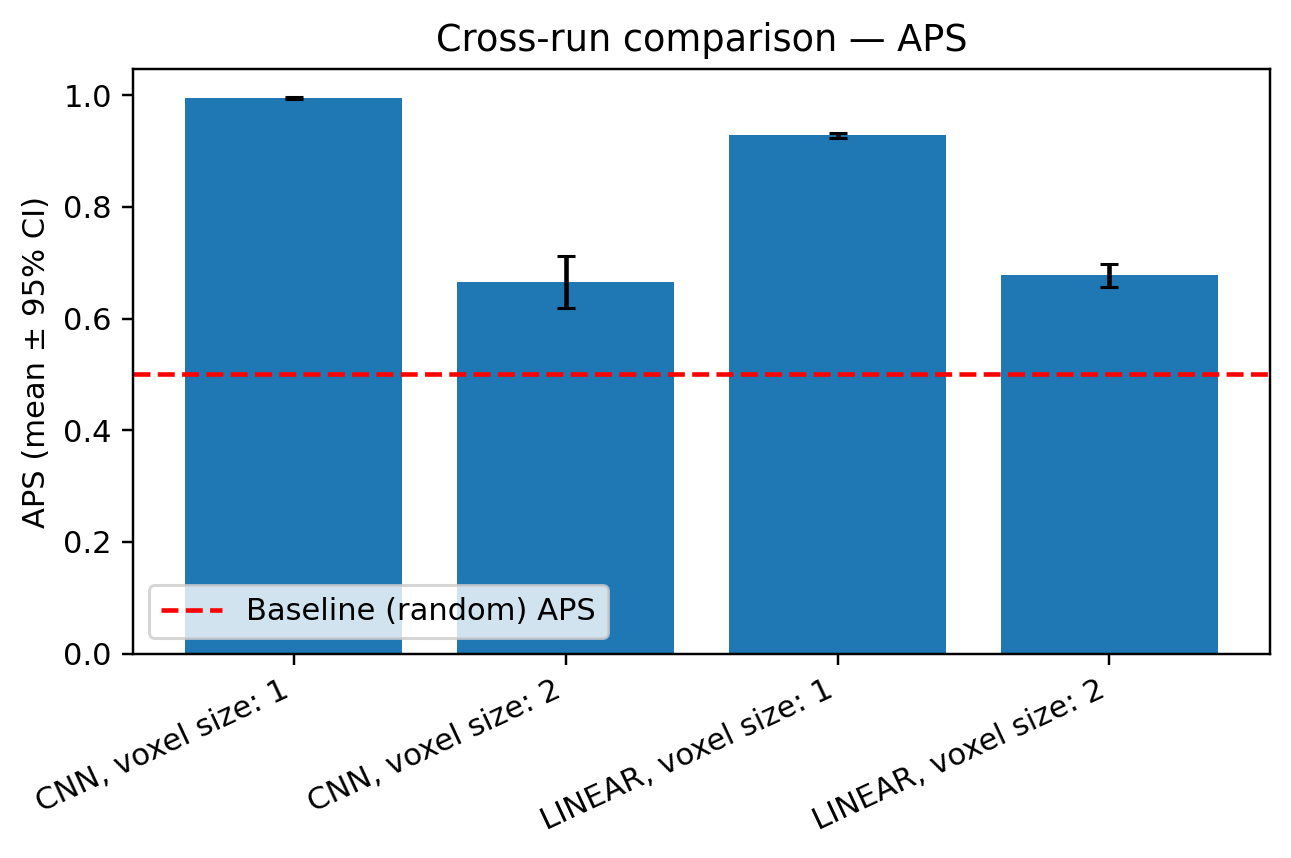

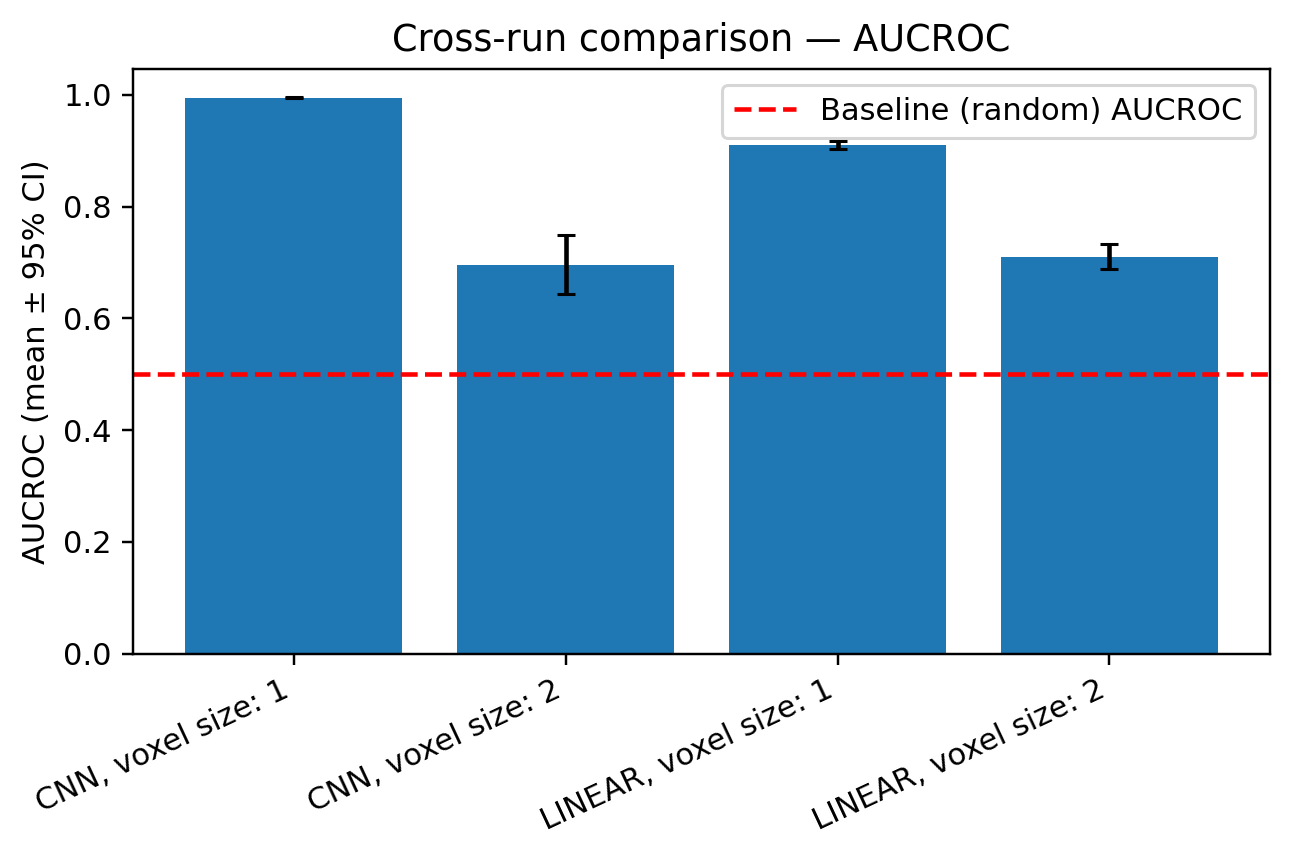

,run,model_name,voxel_size,folds,mean_best_epoch,best_mean_loss,mean_aps,ci_aps_low,ci_aps_high,ci_aps_delta,aps_print,mean_aucroc,ci_aucroc_low,ci_aucroc_high,ci_aucroc_delta,aucroc_print,mean_accuracy,mean_f1
0,vs_1_cnn,cnn,1,5,8.0,0.081041,0.994524,0.992837,0.996212,0.001688,0.99452 ± 0.00169,0.994759,0.993561,0.995956,0.001197,0.99476 ± 0.0012,0.972205,0.974345
2,vs_2_cnn,cnn,2,5,3.0,0.639632,0.665306,0.618626,0.711986,0.046680,0.66531 ± 0.0467,0.696129,0.643389,0.748868,0.052740,0.69613 ± 0.0527,0.630102,0.672757
1,vs_1_linear,linear,1,5,5.0,0.453968,0.927726,0.922522,0.932930,0.005204,0.92773 ± 0.0052,0.910513,0.903045,0.917980,0.007468,0.91051 ± 0.00747,0.819252,0.846788
3,vs_2_linear,linear,2,5,4.0,0.643306,0.677034,0.655910,0.698159,0.021125,0.67703 ± 0.0211,0.710292,0.688102,0.732482,0.022190,0.71029 ± 0.0222,0.651144,0.718413
4,random,random,NaN,5,NaN,0.693,-,NaN,NaN,NaN,0.500,NaN,NaN,NaN,NaN,0.500,0.500,0.500


In [6]:
analyse_runs(dir=CV_LOGS,
             out_dir=CV_ANALYSIS)

# Final Training

In [9]:
def final_training(model_dir: str = '.',
                   folds_dir: str = 'Data/Folds',
                   reduction_factor: int = 2,
                   partially: float = 1,
                   augmented=False,
                   neg_to_pos_ratio=1,
                   voxel_size: int = 1,
                   distance_measure: str = 'euclidean',
                   distance_threshold: int = 4,
                   channels_to_use: Collection[str] = 'all',
                   voxels_dir: str = 'Data/Voxels',
                   batch_size: int = 128,
                   epochs: int = 12,
                   patience: int = 3,
                   shuffle_train: bool = True,
                   seed: int = 1234,
                   custom_run_name: str = None):
    
    # Check the input (not all, the others will be checked anyway later)
    assert isinstance(model_dir, str), f'model_dir must be str, not {type(model_dir)}'
    assert isinstance(custom_run_name, str), f'custom_run_name must be str, not {type(custom_run_name)}'
    assert isinstance(seed, int), f'seed must be int, not {type(seed)}'
    assert 1 <= seed, f'seed be at least 1, not {seed}'
    assert isinstance(patience, int), f'patience must be int, not {type(patience)}'
    assert 1 <= patience, f'patience be at least 1, not {patience}'
    assert isinstance(batch_size, int), f'batch_size must be int, not {type(batch_size)}'
    assert 4 <= batch_size, f'batch_size must be at least 4, not {batch_size}'
    assert isinstance(epochs, int), f'epochs must be int, not {type(epochs)}'
    assert 1 <= epochs, f'epochs must be at least 1, not {epochs}'
    assert isinstance(shuffle_train, bool), f'shuffle_train must be bool, not {type(shuffle_train)}'

    # Set seed
    np.random.seed(seed)
    torch.random.manual_seed(seed)

    # Report
    print('Final Training')
    print(f'Reduction Factor: {reduction_factor}')
    print(f'Augmented: {augmented}')
    print(f'Partially: {partially}')
    print(f'N/P retio: {neg_to_pos_ratio}')
    print(f'Voxel Size: {voxel_size}')
    print(f'Distance Measure: {distance_measure}')
    print(f'Distance Threshold: {distance_threshold}')
    print(f'Channels Used: {channels_to_use}')
    print(f'Batch Size: {batch_size}')
    print(f'Epochs: {epochs}')
    print(f'Seed: {seed}')
    print(f'Name: {custom_run_name}')

    # Create a path
    if model_dir != '.':
        os.makedirs(model_dir, exist_ok=True)

    # Extract all CV folds
    all_folds = [int(f.replace('.csv', '')) for f in os.listdir(folds_dir) if f.replace('.csv', '').isnumeric()]
    all_folds = sorted(all_folds)

    # Create a train set
    train_dataset = SiteDataSet(use_folds=set(all_folds),
                                folds_dir=folds_dir,
                                reduction_factor=reduction_factor,
                                partially=partially,
                                augmented=augmented,
                                neg_to_pos_ratio=neg_to_pos_ratio,
                                voxel_size=voxel_size,
                                distance_measure=distance_measure,
                                distance_threshold=distance_threshold,
                                channels_to_use=channels_to_use,
                                voxels_dir=voxels_dir,
                                seed=seed)
    print(f'Train DataSet created: {len(train_dataset)}')

    # Create Loader
    train_loader = DataLoader(train_dataset, shuffle=shuffle_train, batch_size=batch_size)
    print('DataLoader Created')

    # Create a model according to the name
    if 'linear' in custom_run_name:
        model = LinearRegression(voxel_size=train_dataset.voxel_size)
    else:
        model = FlexibleCNN3D(dropout=0, channel_size=2, voxel_size=train_dataset.voxel_size)
    print(f'Model Created: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters')

    # Train and evaluate the model
    train_evaluate(
        model=model,
        train_loader=train_loader,
        test_loader=None,
        epochs=epochs,
        patience=patience,
        pos_weight=neg_to_pos_ratio,
        save_model=True,
        model_path=os.path.join(model_dir, custom_run_name + '.pt'),
        device='cpu')

After the execution of the cell below 'final_linear.pt' and 'final_cnn.pt' will be stored in the MODEL_DIR (by default, in the current directory)

    IMPORTANT: the final training might take 2-3 hours

In [12]:
rerun = False
if rerun:
    final_training(model_dir=MODEL_DIR, epochs=5, custom_run_name='final_linear', folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)
    final_training(model_dir=MODEL_DIR, epochs=8, custom_run_name='final_cnn', folds_dir=FOLDS_DIR, voxels_dir=VOXELS_DIR)